In [1]:
import sys
import tensorflow as tf
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
sys.path.append("..")
from spatial_transform.aff_mnist_data import IMAGE_SIZE, IMAGE_SHAPE, IMAGE_NUM_CHANNELS, get_aff_mnist_data
from spatial_transform.spatial_transforms import AffineTransform, QuadraticTransform
from spatial_transform.st_blocks import SimpleSpatialTransformBlock
from spatial_transform.localization import StandardConvolutionalLocalizationLayer, CoordConvLocalizationLayer, LargeLocalizationLayer
from spatial_transform.interpolation import BilinearInterpolator
from spatial_transform.layers import RepeatWithSharedWeights
from spatial_transform.visualization import show_train_progress

In [3]:
train_img_data, train_img_label, validation_img_data, validation_img_label, test_img_data, test_img_label = get_aff_mnist_data()

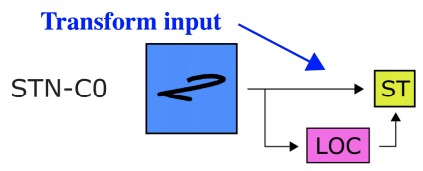

In [4]:
Image("../images/stn_c0.png")

In [5]:
image = tf.keras.layers.Input(shape=IMAGE_SHAPE + (IMAGE_NUM_CHANNELS,))
size_after_transform = 28

# first_spatial_transform = AffineTransform()
# first_st_block = SimpleSpatialTransformBlock(
#     localization_layer = CoordConvLocalizationLayer(
#         spatial_transform_params_cls = first_spatial_transform.param_type,
#         init_scale = size_after_transform / IMAGE_SIZE,
#     ),
#     spatial_transform = first_spatial_transform,
#     interpolator = BilinearInterpolator(),
#     shape_out = (size_after_transform, size_after_transform)
# )

spatial_transform = QuadraticTransform()
st_block = SimpleSpatialTransformBlock(
    localization_layer = LargeLocalizationLayer(
        spatial_transform_params_cls = spatial_transform.param_type,
        init_scale = 1,
    ),
    spatial_transform = spatial_transform,
    interpolator = BilinearInterpolator(),
    shape_out = (size_after_transform, size_after_transform)
)
stn_slx_chain = RepeatWithSharedWeights(layer=st_block, num_repetitions=3)


# input_shape = (40, 40, 1)
# image = tf.keras.layers.Input(shape=input_shape)
# size_after_transform = 28


# interpolation_layer = BilinearInterpolator(height_out=size_after_transform, width_out=size_after_transform)
# stn_slx_block = SimpleSpatialTransformBlock(
#     localization_layer = CoordConvLocalizationLayer(num_spatial_transform_params=interpolation_layer.num_spatial_transform_params),
#     interpolation_layer = interpolation_layer
# )
# stn_slx_chain = RepeatWithSharedWeights(layer=stn_slx_block, num_repetitions=3)

x = tf.image.resize(image, size=(size_after_transform, size_after_transform))
x = stn_slx_chain(x)
x = tf.keras.layers.Conv2D(32, [5, 5], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, [5, 5], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(40, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation=None)(x)

model = tf.keras.models.Model(inputs=image, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
tf.image.resize (TFOpLambda) (None, 28, 28, 1)         0         
_________________________________________________________________
repeat_with_shared_weights ( (None, 28, 28, 1)         72590     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0     

In [6]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [7]:
history = model.fit(
    x = train_img_data, 
    y = train_img_label, 
    batch_size = 128,
    epochs = 6,
    validation_data = (test_img_data,  test_img_label),
    validation_batch_size = 1024,
)

Epoch 1/6
12500/12500 [==============================] - 635s 50ms/step - loss: 1.5705 - accuracy: 0.5477 - val_loss: 0.1647 - val_accuracy: 0.9509
Epoch 2/6
12500/12500 [==============================] - 599s 48ms/step - loss: 0.1620 - accuracy: 0.9510 - val_loss: 0.1057 - val_accuracy: 0.9674
Epoch 3/6
12500/12500 [==============================] - 641s 51ms/step - loss: 0.1045 - accuracy: 0.9680 - val_loss: 0.0777 - val_accuracy: 0.9758
Epoch 4/6
12500/12500 [==============================] - 614s 49ms/step - loss: 0.0812 - accuracy: 0.9749 - val_loss: 0.0756 - val_accuracy: 0.9763
Epoch 5/6
12500/12500 [==============================] - 595s 48ms/step - loss: 0.0683 - accuracy: 0.9789 - val_loss: 0.0689 - val_accuracy: 0.9785
Epoch 6/6
12500/12500 [==============================] - 617s 49ms/step - loss: 0.0605 - accuracy: 0.9812 - val_loss: 0.0635 - val_accuracy: 0.9801


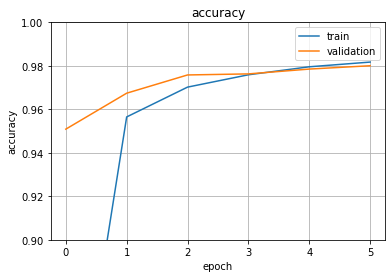

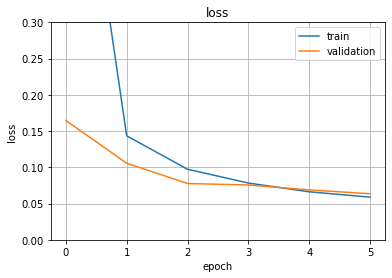

In [8]:
show_train_progress(history)

In [9]:
# model.save_weights("Basic_STN_SLX_coord_network.h5")